In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from flask import Flask, render_template, request, jsonify

In [2]:
# Load dataset
file_path = 'onlinefraud.csv'
df = pd.read_csv(file_path)


In [3]:
# Data Preprocessing
print("Initial dataset info:")
print(df.info())

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
# Handling missing values
df = df.dropna()


In [5]:
# Encoding categorical variables
if 'type' in df.columns:
    le = LabelEncoder()
    df['type_encoded'] = le.fit_transform(df['type'])
else:
    print("Warning: 'type' column not found in dataset.")


In [8]:
# Use a smaller sample for faster training
df_sample = df.sample(frac=0.3, random_state=42)  # 30% of data for training

In [9]:
# Splitting dataset
X = df_sample.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = df_sample['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Model Training - Optimized Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [12]:
# Model Evaluation
y_pred = rf_model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    381277
           1       0.97      0.79      0.87       481

    accuracy                           1.00    381758
   macro avg       0.99      0.90      0.94    381758
weighted avg       1.00      1.00      1.00    381758



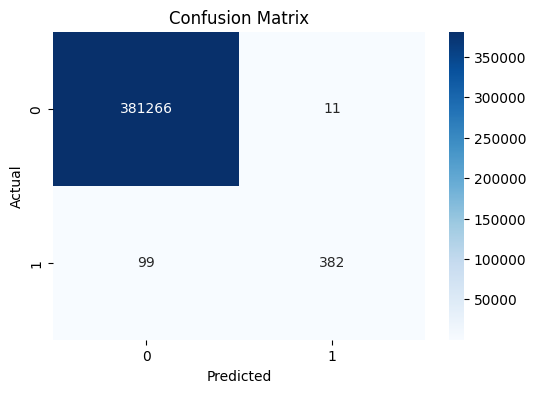

In [13]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

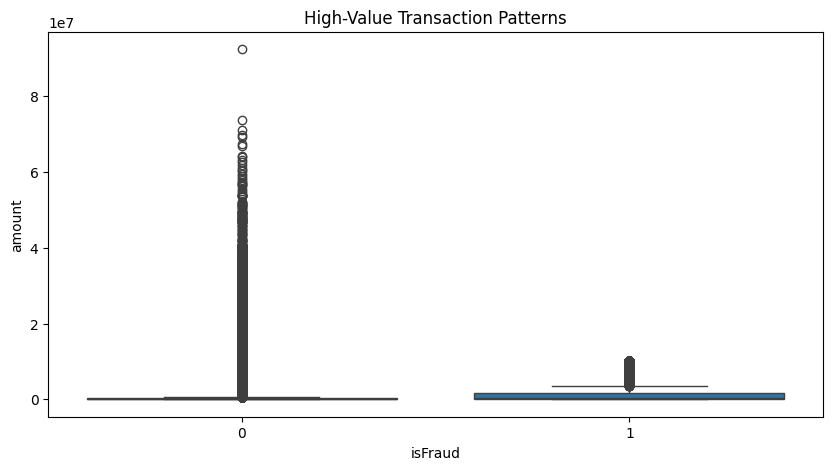

In [19]:
# Behavioral Analysis - Suspicious Activity Detection
df['suspicious'] = df['amount'] > df['amount'].quantile(0.99)
plt.figure(figsize=(10,5))
sns.boxplot(x=df['isFraud'], y=df['amount'])
plt.title("High-Value Transaction Patterns")
plt.show()

In [14]:
# Interactive Dashboard (Flask API Setup)
app = Flask(__name__)


In [15]:
@app.route('/')
def home():
    fraud_summary = df['isFraud'].value_counts().to_dict()
    return {
        "total_transactions": len(df),
        "fraud_transactions": fraud_summary.get(1, 0),
        "legit_transactions": fraud_summary.get(0, 0)
    }

In [20]:
# Real-Time Fraud Detection API
@app.route('/predict', methods=['POST'])
def predict_transaction():
    data = request.json  # Get input from request body
    input_df = pd.DataFrame([data])

    # Apply same preprocessing (encoding, scaling)
    input_df['type_encoded'] = le.transform(input_df['type'])
    input_df = scaler.transform(input_df.drop(['type', 'nameOrig', 'nameDest'], axis=1))

    # Make prediction
    prediction = rf_model.predict(input_df)
    return jsonify({"is_fraud": int(prediction[0])})

In [ ]:
if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
